<H1>CLASSIFICAZIONE SU TITLETYPE CON ONE-HOT ENCODING</H1>

In [1]:
!pip install scikit-plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)


In [3]:
data = pd.read_csv('df_train.csv',  skipinitialspace=True)

In [4]:
df1 = data.copy()

In [5]:
# Lista dei valori unici in 'titleType'
unique_title_types = ['tvEpisode', 'videoGame', 'movie', 'tvSeries', 'video', 'tvMiniSeries', 'short', 'tvMovie', 'tvSpecial', 'tvShort']

# Crea un dizionario di mappatura che assegna un numero a ciascun tipo
title_type_mapping = {title: i + 1 for i, title in enumerate(unique_title_types)}

# Crea una mappatura inversa che assegna il numero alla stringa
reverse_title_type_mapping = {v: k for k, v in title_type_mapping.items()}

# Ora riconverti i numeri nel DataFrame df1 in stringhe
df1['titleType'] = df1['titleType'].map(reverse_title_type_mapping)

# Verifica il risultato
print(df1['titleType'].head())

0    tvEpisode
1    videoGame
2        movie
3     tvSeries
4     tvSeries
Name: titleType, dtype: object


In [6]:
df1.head()

,rating,startYear,runtimeMinutes,awardWins,totalImages,totalVideos,totalCredits,criticReviewsTotal,titleType,awardNominationsExcludeWins,canHaveEpisodes,isAdult,numRegions,userReviewsTotal,ratingCount,countryOfOrigin,genres
0,8,1995,58,0,1,0,21,1,tvEpisode,0,0,0,1,0,781,['US'],"Action,Adventure,Animation"
1,6,1982,58,0,1,0,1,0,videoGame,0,0,0,1,0,11,['XWG'],Action
2,6,1992,58,0,1,0,24,0,movie,0,0,0,1,1,38,['RU'],Comedy
3,6,2021,58,0,22,0,56,0,tvSeries,0,1,0,1,0,15,['MX'],Reality-TV
4,8,2020,80,1,347,2,47,4,tvSeries,1,1,0,32,452,15746,['KR'],"Comedy,Drama,Romance"


In [7]:

# Assumiamo che il tuo dataframe si chiami 'df'
# df = pd.read_csv('tuo_file.csv')  # Se stai leggendo il file CSV

# Applichiamo One-Hot Encoding alle variabili categoriche 'genres', 'countryOfOrigin', 'titleType'

# 1. One-Hot Encoding della variabile 'genres' (attento: può essere più complesso perché è una lista di generi)
df_genres = df1['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])  # Splitta i generi in una lista
df_genres = df_genres.explode().str.get_dummies().groupby(level=0).sum()  # Crea una colonna per ogni genere

# 2. One-Hot Encoding della variabile 'countryOfOrigin'
df_country = df1['countryOfOrigin'].apply(lambda x: x[0] if isinstance(x, list) else x)  # Prende il primo paese se è una lista
df_country = pd.get_dummies(df_country, prefix='country')

# 3. One-Hot Encoding della variabile 'titleType'
df_title_type = pd.get_dummies(df1['titleType'], prefix='titleType')

# 4. Concatenare i dati trasformati con il dataframe originale
df_encoded = pd.concat([df1, df_genres, df_country, df_title_type], axis=1)

# Ora df_encoded contiene le variabili originali e le variabili One-Hot Encoded
# Rimuoviamo le colonne originali non necessarie (se vuoi)
df_encoded = df_encoded.drop(columns=['genres', 'countryOfOrigin', 'titleType'])

# Visualizza i primi 5 record del dataframe trasformato

df = df_encoded.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16416 entries, 0 to 16415
Columns: 764 entries, rating to titleType_videoGame
dtypes: bool(722), int64(42)
memory usage: 16.6 MB


In [8]:
df.head()

,rating,startYear,runtimeMinutes,awardWins,totalImages,totalVideos,totalCredits,criticReviewsTotal,awardNominationsExcludeWins,canHaveEpisodes,...,titleType_movie,titleType_short,titleType_tvEpisode,titleType_tvMiniSeries,titleType_tvMovie,titleType_tvSeries,titleType_tvShort,titleType_tvSpecial,titleType_video,titleType_videoGame
0,8,1995,58,0,1,0,21,1,0,0,...,False,False,True,False,False,False,False,False,False,False
1,6,1982,58,0,1,0,1,0,0,0,...,False,False,False,False,False,False,False,False,False,True
2,6,1992,58,0,1,0,24,0,0,0,...,True,False,False,False,False,False,False,False,False,False
3,6,2021,58,0,22,0,56,0,0,1,...,False,False,False,False,False,True,False,False,False,False
4,8,2020,80,1,347,2,47,4,1,1,...,False,False,False,False,False,True,False,False,False,False


In [9]:
df_trains = df.copy()

<h2> Caricamento e modifica test set</h2>

In [10]:
df_t = pd.read_csv('df_test.csv',  skipinitialspace=True)

In [11]:
df_test = df_t.copy()

In [12]:
import re

# Funzione per convertire i range in interi
def convert_range_to_integer(range_str):
    # Usa una regex per estrarre i numeri dal formato "(x, y]"
    numbers = re.findall(r"[\d.]+", range_str)
    # Il secondo numero (y) è il limite superiore, che corrisponde al valore del rating
    upper_limit = float(numbers[1])
    # Ritorna l'intero corrispondente al limite superiore
    return int(upper_limit)

# Applicare la funzione alla colonna 'rating'
df_test['rating'] = df_test['rating'].apply(convert_range_to_integer)

In [13]:
df_test.head()

,rating,startYear,runtimeMinutes,awardWins,totalImages,totalVideos,totalCredits,criticReviewsTotal,titleType,awardNominationsExcludeWins,canHaveEpisodes,isAdult,numRegions,userReviewsTotal,ratingCount,countryOfOrigin,genres
0,10,2015,21.0,0.0,7,2,11,0,video,0,False,0,1,0,15,['US'],"Music,Short"
1,5,1999,60.0,0.0,10,0,40,9,movie,0,False,0,4,8,304,['HK'],Horror
2,9,2023,60.0,0.0,2,0,6,0,tvSpecial,0,False,0,1,0,10,['US'],Reality-TV
3,7,2020,60.0,0.0,0,0,52,0,tvEpisode,0,False,0,1,0,11,['GB'],Game-Show
4,6,1999,90.0,0.0,2,0,44,1,tvEpisode,0,False,0,1,0,145,['DE'],"Crime,Drama,Mystery"


In [14]:
df_test['canHaveEpisodes'] = df_test['canHaveEpisodes'].astype(int)

In [15]:

# Assumiamo che il tuo dataframe si chiami 'df'
# df = pd.read_csv('tuo_file.csv')  # Se stai leggendo il file CSV

# Applichiamo One-Hot Encoding alle variabili categoriche 'genres', 'countryOfOrigin', 'titleType'

# 1. One-Hot Encoding della variabile 'genres' (attento: può essere più complesso perché è una lista di generi)
df_genres = df_test['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])  # Splitta i generi in una lista
df_genres = df_genres.explode().str.get_dummies().groupby(level=0).sum()  # Crea una colonna per ogni genere

# 2. One-Hot Encoding della variabile 'countryOfOrigin'
df_country = df_test['countryOfOrigin'].apply(lambda x: x[0] if isinstance(x, list) else x)  # Prende il primo paese se è una lista
df_country = pd.get_dummies(df_country, prefix='country')

# 3. One-Hot Encoding della variabile 'titleType'
df_title_type = pd.get_dummies(df_test['titleType'], prefix='titleType')

# 4. Concatenare i dati trasformati con il dataframe originale
df_encoded = pd.concat([df_test, df_genres, df_country, df_title_type], axis=1)

# Ora df_encoded contiene le variabili originali e le variabili One-Hot Encoded
# Rimuoviamo le colonne originali non necessarie (se vuoi)
df_encoded = df_encoded.drop(columns=['genres', 'countryOfOrigin', 'titleType'])

# Visualizza i primi 5 record del dataframe trasformato

df_test = df_encoded.copy()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Columns: 378 entries, rating to titleType_videoGame
dtypes: bool(336), float64(2), int64(40)
memory usage: 3.5 MB


In [16]:
no_coun_train=0
for c in df_trains.columns:
    #print(c)
    no_coun_train+=1
no_coun_test=0
for c in df_test.columns:
    #print(c)
    no_coun_test+=1
print(no_coun_test, no_coun_train)

378 764


In [17]:
df_test = df_test.reindex(columns=df_trains.columns, fill_value=0)
print("clean_train shape:", df_trains.shape)
print("clean_test shape:", df_test.shape)

clean_train shape: (16416, 764)
clean_test shape: (5460, 764)


In [18]:
df_test.head()

,rating,startYear,runtimeMinutes,awardWins,totalImages,totalVideos,totalCredits,criticReviewsTotal,awardNominationsExcludeWins,canHaveEpisodes,...,titleType_movie,titleType_short,titleType_tvEpisode,titleType_tvMiniSeries,titleType_tvMovie,titleType_tvSeries,titleType_tvShort,titleType_tvSpecial,titleType_video,titleType_videoGame
0,10,2015,21.0,0.0,7,2,11,0,0,0,...,False,False,False,False,False,False,False,False,True,False
1,5,1999,60.0,0.0,10,0,40,9,0,0,...,True,False,False,False,False,False,False,False,False,False
2,9,2023,60.0,0.0,2,0,6,0,0,0,...,False,False,False,False,False,False,False,True,False,False
3,7,2020,60.0,0.0,0,0,52,0,0,0,...,False,False,True,False,False,False,False,False,False,False
4,6,1999,90.0,0.0,2,0,44,1,0,0,...,False,False,True,False,False,False,False,False,False,False


<h1> OTTIMIZZAZIONE DEL MODELO CON VALIDATION SET</h1>

<h3> TARGET: titleTypeMovie </h3>

In [19]:
from sklearn.model_selection import train_test_split

# Separiamo le caratteristiche (X) dal target (y)
X = df_trains.drop(columns=['titleType_movie'])  # Rimuoviamo la colonna 'rating' che è il target
y = df_trains['titleType_movie']  # La colonna target è 'rating'

# Dividiamo il dataset in train (80%) e validation (20%)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
print(X_train.shape, X_validation.shape, y_train.shape, y_validation.shape)

(13132, 763) (3284, 763) (13132,) (3284,)


In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
norm = StandardScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_validation_norm = norm.transform(X_validation)

<h1> KNN CLASSIFIER </h1>

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
clf = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights="uniform")
clf.fit(X_train_norm, y_train)

KNeighborsClassifier(metric='euclidean')

In [25]:
# predict: Predict the class labels for the provided data.
y_validation_pred = clf.predict(X_validation_norm)
y_validation_pred

array([False, False, False, ..., False, False, False])

In [26]:
print(classification_report(y_validation, y_validation_pred))

              precision    recall  f1-score   support

       False       0.97      0.95      0.96      2188
        True       0.90      0.94      0.92      1096

    accuracy                           0.95      3284
   macro avg       0.93      0.94      0.94      3284
weighted avg       0.95      0.95      0.95      3284



In [27]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


# Definisci la griglia di ricerca per il modello
param_dist = {
    "n_neighbors": np.arange(1, 201),  # Range per i vicini
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

# Impostiamo il RandomizedSearchCV
random_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_dist,
    n_iter=50,  # Numero di combinazioni da esplorare
    cv=3,  # Numero di fold
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Fit del modello
random_search.fit(X_train_norm, y_train)

# Usa il miglior modello trovato
clf = random_search.best_estimator_

# Stampa i migliori parametri e la performance del miglior modello
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Best Parameters: {'weights': 'distance', 'n_neighbors': 110, 'metric': 'cityblock'}
Best Score: 0.9658848726083461


In [28]:
clf = KNeighborsClassifier(n_neighbors=110, metric="cityblock", weights="distance")
clf.fit(X_train_norm, y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=110, weights='distance')

In [29]:
# predict: Predict the class labels for the provided data.
y_validation_pred = clf.predict(X_validation_norm)
y_validation_pred

array([False, False, False, ..., False, False, False])

In [30]:
print(classification_report(y_validation, y_validation_pred))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      2188
        True       0.96      0.95      0.95      1096

    accuracy                           0.97      3284
   macro avg       0.97      0.96      0.97      3284
weighted avg       0.97      0.97      0.97      3284



In [31]:
N = 50
err = 0

for i in range(N):
    # stratified holdout
    X_rh_train, X_rh_validation, y_rh_train, y_rh_validation = train_test_split(X, y, test_size=0.4, stratify=y)
    
    # normalize train set
    norm.fit(X_rh_train)
    X_rh_train_norm = norm.transform(X_rh_train)
    X_rh_validation_norm = norm.transform(X_rh_validation)

    # initialize and fit classifier
    clf = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights="uniform")
    clf.fit(X_rh_train_norm, y_rh_train)

    # computing error
    acc = clf.score(X_rh_validation_norm, y_rh_validation)
    err += 1 - acc

print("Overall error estimate:", err/N)

Overall error estimate: 0.0656433683569362


In [32]:
from sklearn.model_selection import cross_val_score
k = 4

In [33]:
# initialize classifier
clf = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights="uniform")

scores = cross_val_score(clf, X_train_norm, y_train, cv=k)
scores

array([0.93390192, 0.93390192, 0.93512032, 0.93542492])

In [34]:
print("Overall error estimate:", 1 - scores.mean())

Overall error estimate: 0.065412732257082


In [35]:
# scoring default is accuracy
cross_val_score(clf, X_train_norm, y_train, cv=k, scoring='f1_macro')

array([0.92668548, 0.9271421 , 0.9283378 , 0.92886444])

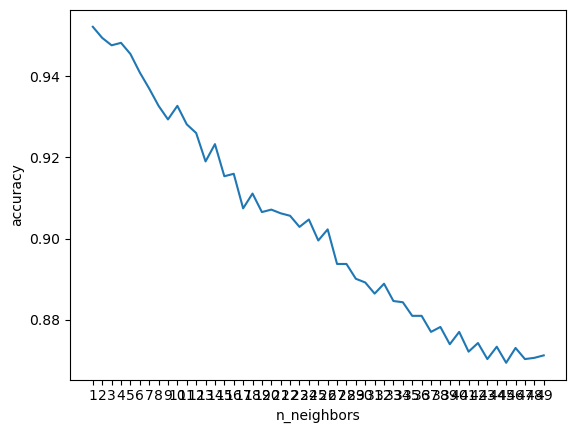

In [36]:
n_neighbors = range(1,50)
scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="euclidean", weights="uniform")
    clf.fit(X_train_norm, y_train)
    scores.append(clf.score(X_validation_norm, y_validation))

plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

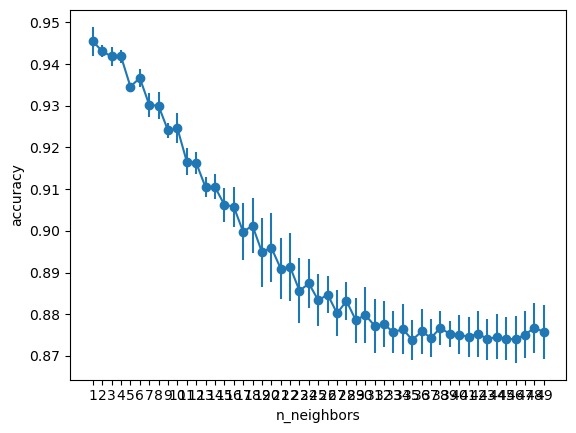

In [37]:
n_neighbors = range(1,50)
avg_scores = list()
std_scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="euclidean", weights="uniform")
    scores = cross_val_score(clf, X_train_norm, y_train, cv=k)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

#plt.plot(avg_scores)
plt.errorbar(range(len(n_neighbors)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

<h1>VALUTAZIONE MODELLO SU TEST SET</h1>

In [39]:
target = 'titleType_movie'  # Definisci il target
attributes = [col for col in df_trains.columns if col != target]  # Ottieni tutte le colonne tranne 'rating'

# Per il training set
X_train = df_trains[attributes]  # Caratteristiche per il training
y_train = df_trains[target]  # Target per il training

# Per il test set
X_test = df_test[attributes]  # Caratteristiche per il test
y_test = df_test[target]  # Target per il test


In [40]:
#Normalizzazione 
from sklearn.preprocessing import StandardScaler

# Inizializziamo lo StandardScaler
norm = StandardScaler()

# Fit e Transform sui dati di allenamento (X_train)
X_train_norm = norm.fit_transform(X_train)

# Solo Transform sui dati di test (X_test)
X_test_norm = norm.transform(X_test)


In [41]:
#PARAMETRI DI RANDOM SEARCH
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=110, metric="cityblock", weights="distance")
clf.fit(X_train_norm, y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=110, weights='distance')

In [42]:
# predict: Predict the class labels for the provided data.
y_test_pred = clf.predict(X_test_norm)
y_test_pred

array([False,  True, False, ...,  True, False, False])

In [43]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.97      0.97      0.97      3590
        True       0.95      0.95      0.95      1870

    accuracy                           0.96      5460
   macro avg       0.96      0.96      0.96      5460
weighted avg       0.96      0.96      0.96      5460



In [44]:
# Return probability estimates for the test data X.
y_test_pred_proba = clf.predict_proba(X_test_norm)
y_test_pred_proba[0:10]

array([[1.        , 0.        ],
       [0.01936455, 0.98063545],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.97997128, 0.02002872],
       [0.23268949, 0.76731051],
       [0.91572098, 0.08427902],
       [0.03084076, 0.96915924],
       [0.44020034, 0.55979966],
       [1.        , 0.        ]])

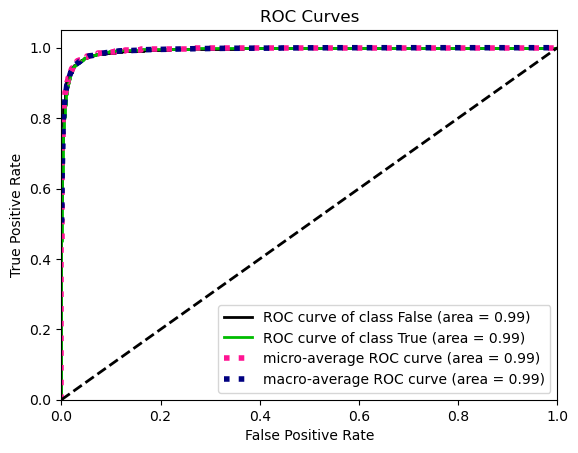

In [46]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
plot_roc(y_test, y_test_pred_proba)
#plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
from sklearn.metrics import roc_auc_score

if len(np.unique(y_validation)) == 2:

    y_test_pred_proba_class1 = y_test_pred_proba[:, 1]
    auc_score = roc_auc_score(y_test, y_test_pred_proba_class1)
else:
    # Classificazione multiclasse!!!!
    auc_score = roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro")

print(f"ROC AUC Score: {auc_score}")

ROC AUC Score: 0.9931958947164585


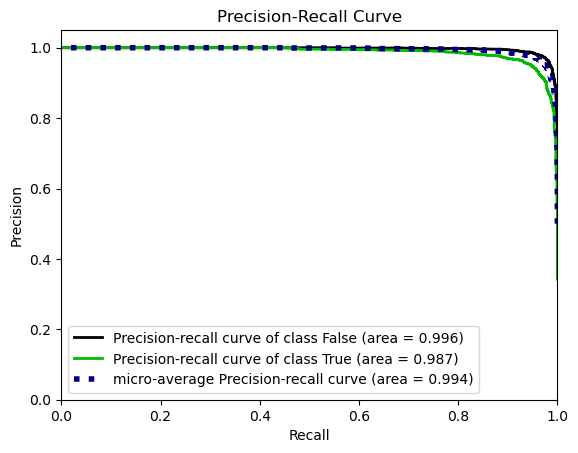

In [48]:
plot_precision_recall(y_test, y_test_pred_proba)
plt.savefig('preicision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

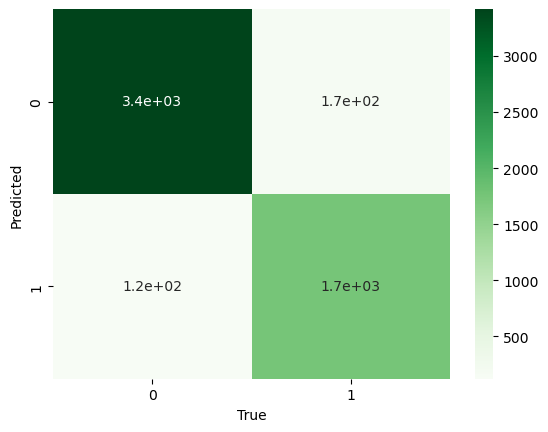

In [58]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.savefig('heatmap_titleType_movie.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
#Classificazione con parametri scelti dal grafico che corrispondono anche al default
clf = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights="uniform")
clf.fit(X_train_norm, y_train)

KNeighborsClassifier(metric='euclidean')

In [51]:
# predict: Predict the class labels for the provided data.
y_test_pred = clf.predict(X_test_norm)
y_test_pred

array([False,  True, False, ...,  True, False, False])

In [52]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.97      0.95      0.96      3590
        True       0.91      0.94      0.92      1870

    accuracy                           0.95      5460
   macro avg       0.94      0.94      0.94      5460
weighted avg       0.95      0.95      0.95      5460



In [53]:
# Return probability estimates for the test data X.
y_test_pred_proba = clf.predict_proba(X_test_norm)
y_test_pred_proba[0:10]

array([[1. , 0. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.4, 0.6],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ]])

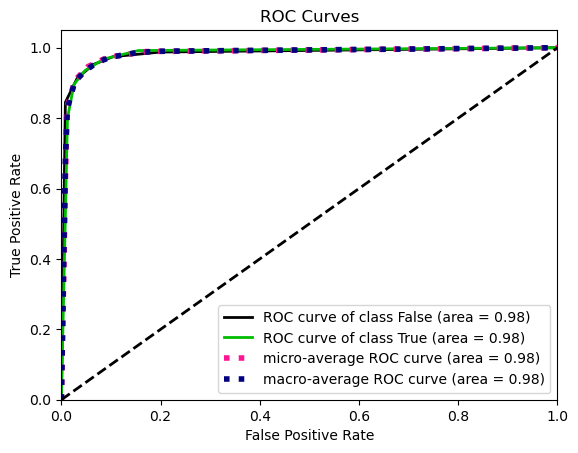

In [54]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
plot_roc(y_test, y_test_pred_proba)
#plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
from sklearn.metrics import roc_auc_score

if len(np.unique(y_validation)) == 2:

    y_test_pred_proba_class1 = y_test_pred_proba[:, 1]
    auc_score = roc_auc_score(y_test, y_test_pred_proba_class1)
else:
    # Classificazione multiclasse!!!!
    auc_score = roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro")

print(f"ROC AUC Score: {auc_score}")

ROC AUC Score: 0.9821454426288114


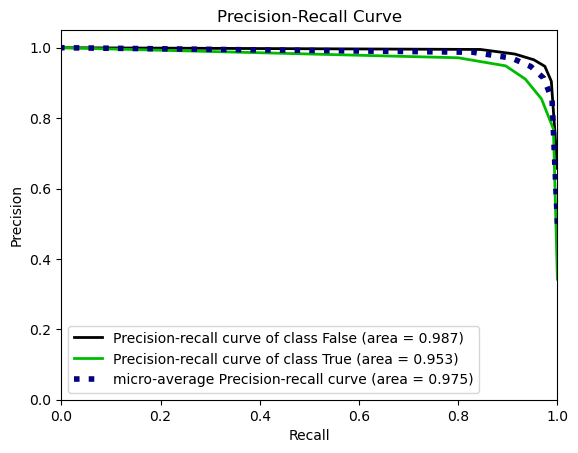

In [56]:
plot_precision_recall(y_test, y_test_pred_proba)
#plt.savefig('preicision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

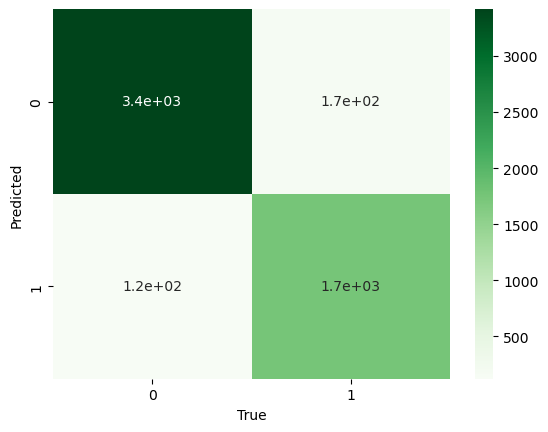

In [57]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()